In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [31]:
class CovarianceFunctions:
    def rbf_kernel(x1, x2, var_sigma, length_scale, noise=None):
        d = cdist(x1, x1) if x2 is None else cdist(x1, x2)
        K = var_sigma * np.exp(-np.power(d, 2)/length_scale)
    
        return K

    def linear_kernel(x1, x2, var_sigma):
        return var_sigma * x1.dot(x1.T) if x2 is None else var_sigma * x1.dot(x2.T)
    
    def white_kernel(x1, x2, var_sigma):
        return var_sigma * np.eye(x1.shape[0]) if x2 is None else np.zeros(x1.shape[0], x2.shape[0])
    
    def periodic_kernel(x1, x2, var_sigma, period, length_scale):
        d = cdist(x1, x1) if x2 is None else cdist(x1, x2)
        
        return var_sigma * np.exp( -(2 * np.sin((np.pi/period)*np.sqrt(d))**2) / length_scale**2)

<ipython-input-44-182718bdc60e>:23: RuntimeWarning: covariance is not positive-semidefinite.
  i = np.random.multivariate_normal(mu, K_periodic, sample_count)


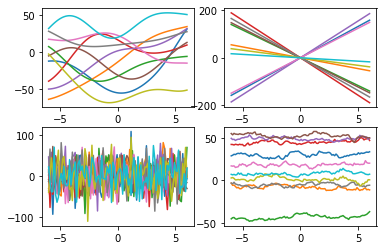

In [44]:
# Choose index set for the marginal.
index_set_size = 100 # The fewer points sampled, the less "smooth", more step-like the function is. I don't know the term here.
x = np.linspace(-6, 6, index_set_size).reshape(-1, 1) # Reshape puts each element in an array of its own.

# Compute covariance matrix by feeding in params to our covariance function.
var_sigma = 1000.0 # I can't tell what the effect of this is by eyeballing.
length_scale = 20.0 # Increasing this smooths out the function.
period = np.pi

K_rbf = CovarianceFunctions.rbf_kernel(x, None, var_sigma, length_scale)
K_linear = CovarianceFunctions.linear_kernel(x, None, var_sigma)
K_white = CovarianceFunctions.white_kernel(x, None, var_sigma)
K_periodic = CovarianceFunctions.periodic_kernel(x, None, var_sigma, period, length_scale)

# Create mean vector
mu = np.zeros(x.shape).reshape(index_set_size,)

# Draw samples from the Gaussian distribution.
sample_count = 10
f = np.random.multivariate_normal(mu, K_rbf, sample_count)
g = np.random.multivariate_normal(mu, K_linear, sample_count)
h = np.random.multivariate_normal(mu, K_white, sample_count)
i = np.random.multivariate_normal(mu, K_periodic, sample_count)

# Plot samples.
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x, f.T);
axs[0, 1].plot(x, g.T);
axs[1, 0].plot(x, h.T);
axs[1, 1].plot(x, i.T);

In [51]:
def gp_prediction(x1, y1, xstar, length_scale, var_sigma, noise, k=CovarianceFunctions.rbf_kernel):
    k_starX = k(xstar, x1, length_scale, var_sigma)
    k_xx = k(x1, None, length_scale, var_sigma)
    k_starstar = k(xstar, None, length_scale, var_sigma)
    
    mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
    variance = k_starstar - k_starX.dot(np.linalg.inv(k_xx)).dot(k_starX.T)
    
    return mu, variance, xstar

In [91]:
N = 5
x = np.linspace(-3.1, 3, N)
y = np.sin(2*np.pi/x) + 0.1 * x + 0.3*np.random.randn(x.shape[0])
x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))
xstar = np.linspace(-6, 6, 500).reshape((-1, 1))

<ipython-input-92-45b59b1022cc>:4: RuntimeWarning: covariance is not positive-semidefinite.
  f_star = np.random.multivariate_normal(mu_star.reshape(xstar.shape[0]), var_star, N_samples)


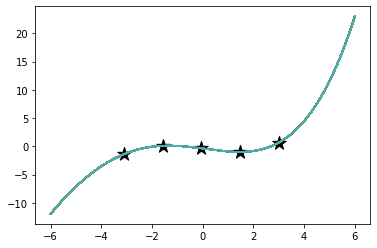

In [92]:
N_samples = 100

mu_star, var_star, x_star = gp_prediction(x, y, xstar, length_scale, var_sigma, 0)
f_star = np.random.multivariate_normal(mu_star.reshape(xstar.shape[0]), var_star, N_samples)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_star, f_star.T)
ax.scatter(x, y, 200, 'k', '*', zorder=2)